# Laboratory 2: Computer Vision
# Part 1: MNIST Digit Classification
유명한 MNIST 데이터 세트에서 손으로 쓴 숫자를 분류하기 위한 CNN(Convolutional Neural Network)을 구축하고 훈련할 것이다. MNIST 데이터 세트는 60,000개의 교육 이미지와 10,000개의 테스트 이미지로 구성된다. 우리 클래스는 0-9자리 숫자이다.

In [1]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

!pip install mitdeeplearning
import mitdeeplearning as mdl

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

     |████████████████████████████████| 2.1 MB 5.4 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115442 sha256=a76817b1f8b12d042f67228109926d1f0294564c24ef50969c9d4ee7711b96a7
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning


# 1.1 MNIST dataset

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)

11501568/11490434 [==============================] - 0s 0us/step


우리의 훈련 세트는 손으로 쓴 숫자는 28x28 그레이스케일 이미지로 구성되어 있다.

이러한 이미지 중 일부와 해당 교육 라벨이 어떻게 생겼는지 시각화해 보자.

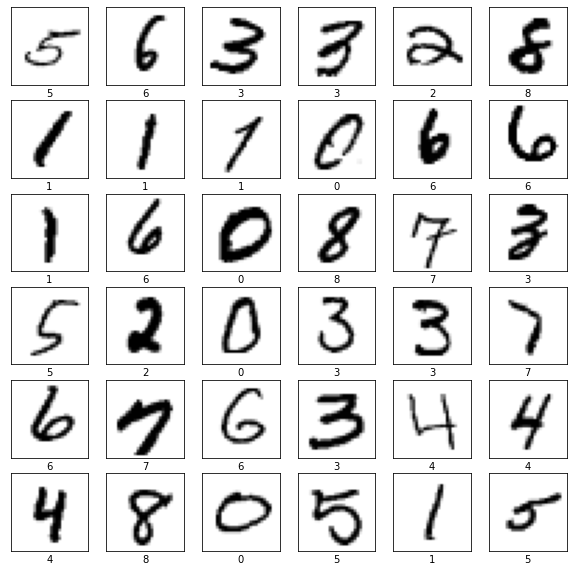

In [3]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind])

# 1.2 Neural Network for Handwritten Digit Classification
우리는 먼저 두 개의 fully connected 레이어로 구성된 간단한 신경망을 구축하고 이를 수치 분류 작업에 적용할 것이다. 우리의 네트워크는 궁극적으로 10자리 클래스(0-9)에 대한 확률 분포를 출력할 것이다. 

## Fully connected neural network architecture
이 첫 번째 fully connected 신경망의 아키텍처를 정의하기 위해 Keras API를 다시 사용하고 Sequential 클래스를 사용하여 모델을 정의한다. 먼저 Flatten 레이어를 사용하면 input이 모델에 입력될 수 있다.

다음 블록에서는 이 간단한 작업의 fully connected 레이어를 정의한다.

In [4]:
def build_fc_model():
  fc_model = tf.keras.Sequential([
      # First define a Flatten layer
      tf.keras.layers.Flatten(),

      # '''TODO: Define the activation function for the first fully connected (Dense) layer.'''
      tf.keras.layers.Dense(128, activation=tf.nn.relu),

      # '''TODO: Define the second Dense layer to output the classification probabilities'''
      tf.keras.layers.Dense(10, activation=tf.nn.softmax) 
      
  ])
  return fc_model

model = build_fc_model()

activation function은 약속인걸까?

이 다음 부분을 진행하면서 위에서 정의한 아키텍처를 변경해야 할 수도 있다. *나중에 모델을 업데이트하려면 위의 셀을 다시 실행하여 모델을 다시 초기화해야 한다.*

한 걸음 뒤로 물러서서 우리가 방금 만든 네트워크에 대해 생각해 보자. 이 네트워크의 첫 번째 계층은 tf.keras.layers.Flatten이다.영상 형식을 2d 배열(28 x 28 픽셀)에서 28 * 28 = 784 픽셀의 1d 배열로 변환한다. 이 레이어는 이미지에서 픽셀 행을 분할하여 정렬하는 것으로 생각할 수 있다. 이 레이어에는 학습된 매개 변수가 없으며 데이터만 다시 포맷한다.

픽셀이 평평해지면 네트워크는 두 개의 tf.keras.layers.Dense 레이어 시퀀스로 구성된다. 이것들은 fully-connected 신경층이다. 첫 번째 Dense 레이어는 128개의 노드(또는 뉴런)를 가지고 있다. 두 번째(그리고 마지막) 레이어 (정의한 항목!)는 합계가 1인 확률 점수 배열을 반환해야 한다. 각 노드에는 현재 이미지가 필기된 숫자 클래스 중 하나에 속할 확률을 나타내는 점수가 포함된다.

그것이 우리의 fully connected 모델을 규정한다!

## Compile the model
모델을 교육하기 전에 몇 가지 설정을 더 정의해야 한다. 다음 요소는 모델의 컴파일 단계에서 추가된다:

* Loss function — 교육 중에 모델이 얼마나 정확한지 측정하는 방법을 정의한다. 교육 중에는 모델을 올바른 방향으로 "steer"하는 이 기능을 최소화하고자한다.
* Optimizer — 표시되는 데이터와 손실 함수를 기준으로 모델이 업데이트되는 방식을 정의한다.
* Metrics — 여기서 교육 및 테스트 단계를 모니터링하는 데 사용되는 Metrics을 정의할 수 있다. 이 예에서는 정확하게 분류된 이미지의 일부인 정확성을 살펴본다.

우리는 0.1의 학습률로 초기화된 stochastic gradient descent(SGD) 최적화 도구를 사용하여 시작할 것이다. 범주 분류 작업을 수행 중이기 때문에 cross entropy loss를 사용한다.

Optimizer와 learning rate를 모두 사용하여 실험하고 이러한 선택 사항이 훈련된 모델의 정확도에 어떤 영향을 미치는지 평가할 수 있다.

In [5]:
'''TODO: Experiment with different optimizers and learning rates. How do these affect
    the accuracy of the trained model? Which optimizers and/or learning rates yield
    the best performance?'''
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model
이제 모델을 교육할 준비가 되었다. 학습 데이터(train_images 및 train_labels)를 모델에 입력한 다음 이미지와 레이블 간의 연관성을 학습하도록 요청한다. 또한 학습 중에 사용할 배치 크기와 MNIST 데이터 세트에 대한 Epoch 또는 반복 횟수를 정의해야 한다.

실습 1에서는 GradientTape를 사용하여 손실을 최적화하고 stochastic gradient descent로 모델을 교육하는 방법을 살펴보았다. 컴파일 단계에서 모델 설정을 정의한 후 모델 클래스의 인스턴스에서 fit 메소드를 호출하여 교육을 수행할 수도 있다. 우리는 이것을 사용하여 fully connected 모델을 교육할 것이다.

In [6]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 64
EPOCHS = 5

model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
938/938 [==============================] - 8s 5ms/step - loss: 0.3755 - accuracy: 0.8950
Epoch 2/5
938/938 [==============================] - 5s 5ms/step - loss: 0.1992 - accuracy: 0.9430
Epoch 3/5
938/938 [==============================] - 4s 5ms/step - loss: 0.1487 - accuracy: 0.9579
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1198 - accuracy: 0.9661
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1000 - accuracy: 0.9720


모델이 훈련하면서 손실 및 정확도 메트릭이 표시된다. 5개의 Epoch와 0.01의 학습률을 가진 이 fully connected 모델은 훈련 데이터에서 약 0.97(또는 97%)의 정확도를 달성해야 한다.

## Evaluate accuracy on the test dataset
이제 모델을 교육했으므로 이전에는 보지 못했던 테스트 세트를 예측하도록 요청할 수 있다. 이 예에서 test_images 배열은 테스트 데이터 세트를 구성한다. 정확성을 평가하기 위해 모델의 예측이 test_labels 배열의 레이블과 일치하는지 확인할 수 있다.

evaluate 메소드를 사용하여 테스트 데이터 세트에서 모델을 평가하자

In [7]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.1088 - accuracy: 0.9677
Test accuracy: 0.9677000045776367


테스트 데이터 세트의 정확도가 교육 데이터 세트의 정확도보다 약간 낮다는 것을 관찰할 수 있다. 훈련 정확도와 시험 정확도 사이의 이러한 차이는 기계 학습 모델이 훈련 데이터보다 새 데이터에서 성능이 떨어지는 **과적합** 사례이다.

이 첫 번째 fully connected 모델에서 얻을 수 있는 최고의 정확도는 얼마입니까? 손으로 쓴 숫자 분류 작업은 매우 간단하기 때문에, 여러분은 우리가 어떻게 더 잘 할 수 있는지 궁금해 할 것이다.

# 1.3 Convolutional Neural Network (CNN) for handwritten digit classification
컨볼루션 신경망(CNN)은 특히 컴퓨터 비전의 다양한 작업에 적합하며 MNIST 데이터 세트에서 거의 완벽한 정확도를 달성했다. 이제 두 개의 컨볼루션 레이어와 풀링 레이어로 구성된 CNN을 구축한 다음 두 개의 fully connected 레이어로 구성하고 궁극적으로 10자리 클래스(0-9)에 걸친 확률 분포를 출력할 것이다. 

## Define the CNN model
이전과 동일한 교육 및 테스트 데이터 세트를 사용하고 fully connected 네트워크와 유사하게 진행하여 새로운 CNN 모델을 정의하고 교육할 것이다.이를 위해 우리는 이전에 경험하지 못했던 두 개의 레이어를 살펴볼 것이다: keras.layers.Conv2D를 사용하여 컨볼루션 레이어를 정의하고 keras.layers.MaxPool2D를 사용하여 풀링 레이어를 정의할 수 있다. 위의 네트워크 아키텍처에 표시된 매개변수를 사용하여 이러한 계층을 정의하고 CNN 모델을 구축한다.

In [8]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([

        # TODO: Define the first convolutional layer
        tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3), activation=tf.nn.relu), 

        # TODO: Define the first max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        # TODO: Define the second convolutional layer
        tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3), activation=tf.nn.relu),

        # TODO: Define the second max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),

        # TODO: Define the last Dense layer to output the classification 
        # probabilities. Pay attention to the activation needed a probability
        # output
        
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
        # '''TODO: Dense layer to output classification probabilities'''
    ])
    
    return cnn_model
  
cnn_model = build_cnn_model()
# Initialize the model by passing some data through
cnn_model.predict(train_images[[0]])
# Print the summary of the layers in the model.
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 24)        240       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 24)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 36)        7812      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 36)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 900)               0         
                                                                 
 dense_2 (Dense)             (None, 128)              

## Train and test the CNN model
이제 이전처럼 컴파일 방법을 통해 손실 함수, optimizer, 메트릭을 정의할 수 있습니다. 선택의 optimizer와 learning rate를 사용하여 CNN 모델을 컴파일한다:

In [9]:
'''TODO: Define the compile operation with your optimizer and learning rate of choice'''
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy']) # TODO

fully connected 모델의 경우와 마찬가지로, 우리는 Keras API를 통해 fit 메소드를 사용하여 CNN을 훈련시킬 수 있다.

In [10]:
'''TODO: Use model.fit to train the CNN model, with the same batch_size and number of epochs previously used.'''
cnn_model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
938/938 [==============================] - 7s 6ms/step - loss: 0.1848 - accuracy: 0.9434
Epoch 2/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0545 - accuracy: 0.9832
Epoch 3/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0388 - accuracy: 0.9881
Epoch 4/5
938/938 [==============================] - 6s 7ms/step - loss: 0.0288 - accuracy: 0.9906
Epoch 5/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0237 - accuracy: 0.9921


좋습니다! 이제 모델을 교육했으므로 evaluate 메소드를 사용하여 테스트 데이터 세트에서 평가해 보자.

In [11]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = model.evaluate(test_images,test_labels)

print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.1088 - accuracy: 0.9677
Test accuracy: 0.9677000045776367


CNN 모델을 사용하여 얻을 수 있는 가장 높은 정확도는 무엇이며, CNN 모델의 정확도와 단순하게 완전히 연결된 네트워크의 정확도는 어떻게 비교될까? CNN 모델 훈련에 어떤optimizers와 learning rates이 가장 적합할까?

## Make predictions with the CNN model
모델이 훈련되면, 우리는 그것을 사용하여 몇몇 이미지에 대한 예측을 할 수 있다. 예측 함수 호출은 입력 샘플 집합이 주어진 출력 예측을 생성한다.

In [12]:
predictions = cnn_model.predict(test_images)

이 함수 호출을 통해 모델은 테스트 세트의 각 이미지에 대한 레이블을 예측했다. 테스트 데이터 세트의 첫 번째 이미지에 대한 예측을 살펴보자.

In [13]:
predictions[0]

array([7.4688714e-08, 7.2291544e-07, 6.9882290e-08, 2.6764474e-06,
       5.3716267e-09, 3.3156985e-10, 8.6876062e-12, 9.9999630e-01,
       6.7454753e-09, 7.6801342e-08], dtype=float32)

보시다시피, 예측은 10개의 숫자로 구성된 배열이다. 우리 모델의 출력은 10자리 클래스에 걸친 확률 분포라는 것을 기억하자. 따라서 이 숫자들은 이미지가 10개의 다른 숫자에 대응한다는 모델의 "confidence"을 나타낸다.

테스트 데이터 세트의 첫 번째 이미지에 대한 신뢰도가 가장 높은 숫자를 살펴보자:

In [14]:
'''TODO: identify the digit with the highest confidence prediction for the first
    image in the test dataset. '''
prediction = np.argmax(predictions[0]) 
# 가장 큰 값을 가진 index

print(prediction)

7


그래서 이 모델은 이 이미지가 "???"라고 가장 자신한다. 이 예측이 정확한지 확인하기 위해 테스트 라벨을 확인할 수 있다.

Label of this digit is: 7


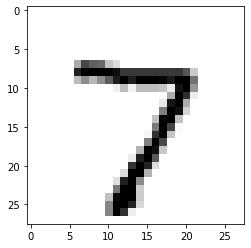

In [15]:
print("Label of this digit is:", test_labels[0])
plt.imshow(test_images[0,:,:,0], cmap=plt.cm.binary)

MNIST 데이터 세트에서 분류 결과를 시각화해 보자. 테스트 데이터 세트의 이미지를 예측 레이블과 함께 플롯하고 각 자릿수에 대한 예측 확률을 제공하는 히스토그램도 표시한다.

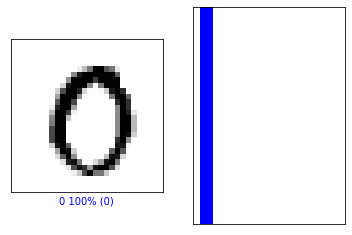

In [19]:
#@title Change the slider to look at the model's predictions! { run: "auto" }

image_index = 13 #@param {type:"slider", min:0, max:100, step:1}
plt.subplot(1,2,1)
mdl.lab2.plot_image_prediction(image_index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
mdl.lab2.plot_value_prediction(image_index, predictions,  test_labels)

또한 올바른 예측 레이블이 파란색이고 잘못된 예측 레이블이 회색인 여러 이미지를 예측과 함께 플롯할 수 있다. 숫자는 예측 레이블에 대한 백분율(100점 만점)을 제공한다. 이 모형은 잘못된 예측에 대해 매우 신뢰할 수 있다!

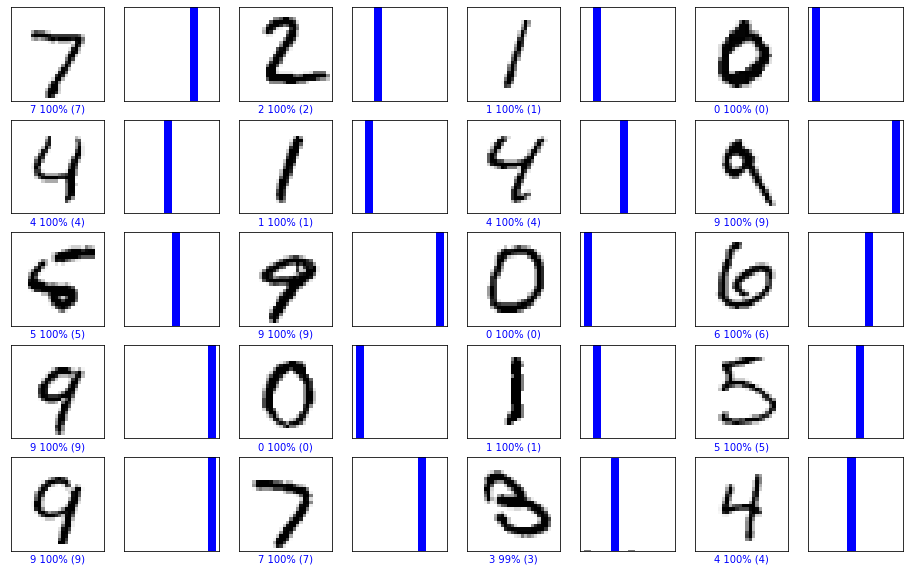

In [20]:
# Plots the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  mdl.lab2.plot_image_prediction(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  mdl.lab2.plot_value_prediction(i, predictions, test_labels)

# 1.4 Training the model 2.0
실험 초기에, 우리는 모델을 훈련시키기 위해  fit 함수 호출을 사용다. 이 함수는 매우 높은 수준으로 직관적이어서 간단한 모델에 매우 유용하다. 아시다시피, 이 기능은 **training call**에서 많은 세부 정보를 추상화하며, 학습 모델에 대한 제어력이 떨어지기 때문에 다른 상황에서 유용할 수 있다.

이에 대한 대안으로 tf.GradientTape 클래스를 사용하여 훈련 중 차별화 작업을 기록한 다음 tf.GradientTape.gradient 함수를 호출하여 실제로 그레이디언트를 계산할 수 있다. 당신은 이것을 1번 랩 파트 1에서 본 것을 기억할지 모르지만, 여기서 이것을 다시 살펴보자.

우리는 이 프레임워크를 사용하여 stochastic gradient descent를 사용하여 cnn_model을 훈련시킬 것이다.

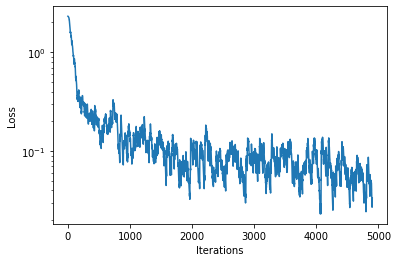

100%|██████████| 5000/5000 [01:33<00:00, 53.68it/s]


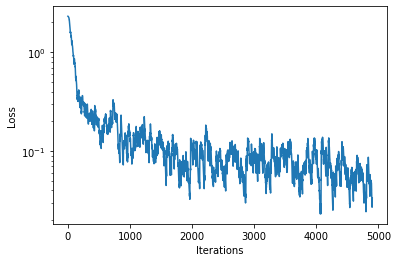

In [21]:
# Rebuild the CNN model
cnn_model = build_cnn_model()

batch_size = 12
loss_history = mdl.util.LossHistory(smoothing_factor=0.95) # to record the evolution of the loss
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2) # define our optimizer

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for idx in tqdm(range(0, train_images.shape[0], batch_size)):
  # First grab a batch of training data and convert the input images to tensors
  (images, labels) = (train_images[idx:idx+batch_size], train_labels[idx:idx+batch_size])
  images = tf.convert_to_tensor(images, dtype=tf.float32)

  # GradientTape to record differentiation operations
  with tf.GradientTape() as tape:
    #'''TODO: feed the images into the model and obtain the predictions'''
    logits = cnn_model(images)

    #'''TODO: compute the categorical cross entropy loss
    loss_value = tf.keras.backend.sparse_categorical_crossentropy(labels, logits) # TODO

  loss_history.append(loss_value.numpy().mean()) # append the loss to the loss_history record
  plotter.plot(loss_history.get())

  # Backpropagation
  '''TODO: Use the tape to compute the gradient against all parameters in the CNN model.
      Use cnn_model.trainable_variables to access these parameters.''' 
  grads = tape.gradient(loss_value, cnn_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, cnn_model.trainable_variables))

# 1.5 Conclusion
lab의 이 부분에서는 서로 다른 아키텍처(fully-connected 레이어 전용, CNN)를 사용하는 다양한 MNIST 분류기를 사용하고 서로 다른 하이퍼 파라미터가 정확도에 어떤 영향을 미치는지 실험해 볼 기회가 있었다(learning rate 등). 실험실의 다음 부분에서는 CNN의 또 다른 응용 프로그램, 안면 감지 및 bias 문제와 같은 실제 응용 프로그램의 AI 시스템의 몇 가지 단점을 살펴보자.
